In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score,cross_validate, RandomizedSearchCV, train_test_split
import optuna
import xgboost as xgb
from sklearn.metrics import r2_score 
import joblib
from sklearn.preprocessing import RobustScaler

In [2]:
df2 = pd.read_excel("../markaFile/Mercedes.xlsx",sheet_name="Sheet1")

In [3]:
df2.drop("Unnamed: 0",axis=1, inplace=True)

In [4]:
df2.head()

,Fiyat,Yıl,Motor Gücü,Motor Hacmi,Kilometre,Boya,Değişen,Seri_190,Seri_200,Seri_220,...,Model_SE,Model_SEL,Model_TD,Model_TE,Yakıt Tipi_Benzin,Yakıt Tipi_Dizel,Yakıt Tipi_LPG & Benzin,Vites Tipi_Düz,Vites Tipi_Otomatik,Vites Tipi_Yarı Otomatik
0,1450000,0.363636,3.027778,2.072115,-0.411985,NaN,NaN,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,145000,-2.181818,0.583333,2.100962,1.648689,12.0,0.0,1,0,0,...,0,0,0,0,0,0,1,1,0,0
2,1450000,0.363636,1.500000,0.168269,-0.494382,0.0,0.0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3,1380000,0.454545,0.944444,0.182692,0.077468,3.0,2.0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
4,1175000,0.181818,1.500000,0.168269,0.089888,2.0,0.0,0,0,0,...,0,0,0,0,1,0,0,0,1,0


In [5]:
y = df2["Fiyat"]
X = df2.drop(["Fiyat"], axis=1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [7]:
def set_model(model_list, X_train, X_test, y_train, y_test):
    dataf = pd.DataFrame()

    for i in range(len(model_list)):
        algo_name = model_list[i][0]
        algo = model_list[i][1]

        model = algo.fit(X_train, y_train)

        cv_result = cross_val_score(model,
                                    X_train, y_train,
                                    cv=5,
                                    scoring="neg_mean_squared_error")

        y_pred = model.predict(X_test)
        rmse = np.mean(np.sqrt(-cv_result))
        data_list = {"Model": algo_name,
                     "TestDeger": rmse,
                     "MSE":mean_squared_error(y_test, y_pred),
                     "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
                     "MAE": mean_absolute_error(y_test, y_pred)}
        dataf = dataf.append(data_list, ignore_index=True)

    return dataf

In [8]:
models = []
#models.append(('Gradient Boosting Regressor', GradientBoostingRegressor()))
models.append(('XGBModel', XGBRegressor(objective="reg:squarederror",use_label_encoder=False)))
#models.append(('LGBMModel', LGBMRegressor(use_missing=False)))
#models.append(('LRModel', LinearRegression()))
#models.append(('RFModel', RandomForestRegressor()))

In [9]:
df2_model = set_model(models, X_train, X_test, y_train, y_test)
df2_model

C:\Users\senab\AppData\Local\Temp\ipykernel_4532\3059390516.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataf = dataf.append(data_list, ignore_index=True)


,Model,TestDeger,MSE,RMSE,MAE
0,XGBModel,551957.443888,5.837208e+11,764016.225032,213200.456556


In [10]:
def objective(n_trials):
  params = {
        'colsample_bytree': n_trials.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': n_trials.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        "learning_rate": n_trials.suggest_float("learning_rate", 1e-4, 0.5, log=True),
        'n_estimators': 10000,
        "max_depth": n_trials.suggest_int("max_depth", 3, 15),
        'min_child_weight': n_trials.suggest_int('min_child_weight', 1, 300),
    }
  dtrain = xgb.DMatrix(data = X_train, label = y_train)
  dval = xgb.DMatrix(data = X_test, label = y_test)

  regressor = xgb.train(params, dtrain) 
  y_pred = regressor.predict(dval)
  rmse = mean_squared_error(y_test, y_pred, squared=False)

  return rmse

In [11]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=250, n_jobs=-1)

[I 2023-05-23 21:09:02,875] A new study created in memory with name: no-name-9f8c117e-7d4c-4560-b4fa-5a9d0437c35f
[I 2023-05-23 21:09:03,239] Trial 2 finished with value: 1937630.9413629945 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.24184000168958986, 'max_depth': 10, 'min_child_weight': 264}. Best is trial 2 with value: 1937630.9413629945.
[I 2023-05-23 21:09:03,300] Trial 4 finished with value: 830458.3174000485 and parameters: {'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.3764402414048525, 'max_depth': 3, 'min_child_weight': 18}. Best is trial 4 with value: 830458.3174000485.
[I 2023-05-23 21:09:03,380] Trial 0 finished with value: 2555853.2514300044 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.00456376623129535, 'max_depth': 10, 'min_child_weight': 125}. Best is trial 4 with value: 830458.3174000485.
[I 2023-05-23 21:09:03,409] Trial 1 finished with value: 2606920.322322199 and parameters: {'cols

[I 2023-05-23 21:09:05,613] Trial 28 finished with value: 1771940.57105714 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.395879400348186, 'max_depth': 3, 'min_child_weight': 262}. Best is trial 18 with value: 802842.5580641511.
[I 2023-05-23 21:09:05,638] Trial 34 finished with value: 2381840.1889941483 and parameters: {'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.021384965787188993, 'max_depth': 3, 'min_child_weight': 233}. Best is trial 18 with value: 802842.5580641511.
[I 2023-05-23 21:09:05,646] Trial 31 finished with value: 2409815.266320299 and parameters: {'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.018497087527671655, 'max_depth': 12, 'min_child_weight': 229}. Best is trial 18 with value: 802842.5580641511.
[I 2023-05-23 21:09:05,675] Trial 32 finished with value: 1585931.2577138778 and parameters: {'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.12955481224488538, 'max_depth': 3, 'min_child_weigh

[I 2023-05-23 21:09:08,283] Trial 60 finished with value: 1227875.433391046 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.10717745167218617, 'max_depth': 8, 'min_child_weight': 14}. Best is trial 53 with value: 801317.4226796777.
[I 2023-05-23 21:09:08,376] Trial 61 finished with value: 1360482.5371837313 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.0911536981632063, 'max_depth': 15, 'min_child_weight': 14}. Best is trial 53 with value: 801317.4226796777.
[I 2023-05-23 21:09:08,545] Trial 62 finished with value: 1266078.2980454415 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.10304309579729468, 'max_depth': 13, 'min_child_weight': 16}. Best is trial 53 with value: 801317.4226796777.
[I 2023-05-23 21:09:08,696] Trial 63 finished with value: 1554293.899162218 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.0976187761478022, 'max_depth': 13, 'min_child_weight'

[I 2023-05-23 21:09:11,261] Trial 88 finished with value: 836833.351013916 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.5, 'learning_rate': 0.3900014148748578, 'max_depth': 12, 'min_child_weight': 2}. Best is trial 73 with value: 785588.6020338975.
[I 2023-05-23 21:09:11,261] Trial 89 finished with value: 981507.5949995763 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.5, 'learning_rate': 0.24897271998936737, 'max_depth': 10, 'min_child_weight': 1}. Best is trial 73 with value: 785588.6020338975.
[I 2023-05-23 21:09:11,814] Trial 92 finished with value: 835718.9793497594 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.20764119168572912, 'max_depth': 12, 'min_child_weight': 1}. Best is trial 73 with value: 785588.6020338975.
[I 2023-05-23 21:09:12,170] Trial 94 finished with value: 1785570.8325053426 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.24173445412917882, 'max_depth': 12, 'min_child_weight': 1

[I 2023-05-23 21:09:14,886] Trial 119 finished with value: 814623.2525027643 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.4207991524946525, 'max_depth': 9, 'min_child_weight': 18}. Best is trial 120 with value: 778549.1666492573.
[I 2023-05-23 21:09:14,983] Trial 121 finished with value: 814933.2652185879 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.43245430697139264, 'max_depth': 8, 'min_child_weight': 18}. Best is trial 120 with value: 778549.1666492573.
[I 2023-05-23 21:09:15,182] Trial 122 finished with value: 824925.1622864787 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.4211869514713273, 'max_depth': 8, 'min_child_weight': 16}. Best is trial 120 with value: 778549.1666492573.
[I 2023-05-23 21:09:15,258] Trial 123 finished with value: 793851.9756396962 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.4021071931395283, 'max_depth': 8, 'min_child_weight

[I 2023-05-23 21:09:18,321] Trial 149 finished with value: 1030760.2300775178 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.17743571328531255, 'max_depth': 10, 'min_child_weight': 35}. Best is trial 129 with value: 761770.9414030106.
[I 2023-05-23 21:09:18,420] Trial 151 finished with value: 1043054.43945692 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.229573709593663, 'max_depth': 10, 'min_child_weight': 47}. Best is trial 129 with value: 761770.9414030106.
[I 2023-05-23 21:09:18,464] Trial 152 finished with value: 1134515.9656642657 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.22790637015297982, 'max_depth': 10, 'min_child_weight': 58}. Best is trial 129 with value: 761770.9414030106.
[I 2023-05-23 21:09:18,662] Trial 154 finished with value: 1113198.1854861376 and parameters: {'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.21151265732021232, 'max_depth': 10, 'min_child

[I 2023-05-23 21:09:21,469] Trial 180 finished with value: 846942.0942973475 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.40965984011164586, 'max_depth': 8, 'min_child_weight': 7}. Best is trial 129 with value: 761770.9414030106.
[I 2023-05-23 21:09:21,650] Trial 181 finished with value: 824149.7961325799 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.4177321160733893, 'max_depth': 8, 'min_child_weight': 20}. Best is trial 129 with value: 761770.9414030106.
[I 2023-05-23 21:09:22,045] Trial 182 finished with value: 766456.6476452411 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.4066316847977618, 'max_depth': 8, 'min_child_weight': 29}. Best is trial 129 with value: 761770.9414030106.
[I 2023-05-23 21:09:22,129] Trial 183 finished with value: 818716.6990800117 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.40071385792000935, 'max_depth': 8, 'min_child_weight

[I 2023-05-23 21:09:24,832] Trial 211 finished with value: 1716116.6563613617 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.062405596835625424, 'max_depth': 8, 'min_child_weight': 29}. Best is trial 202 with value: 749127.1254297486.
[I 2023-05-23 21:09:24,833] Trial 210 finished with value: 784500.5223681921 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.3564950415214859, 'max_depth': 8, 'min_child_weight': 29}. Best is trial 202 with value: 749127.1254297486.
[I 2023-05-23 21:09:25,026] Trial 212 finished with value: 795237.9404526342 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.3550926137663646, 'max_depth': 8, 'min_child_weight': 29}. Best is trial 202 with value: 749127.1254297486.
[I 2023-05-23 21:09:25,247] Trial 213 finished with value: 867533.7367422275 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.49796318187986255, 'max_depth': 8, 'min_child_wei

[I 2023-05-23 21:09:28,251] Trial 242 finished with value: 830176.7339392127 and parameters: {'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.45374375782090676, 'max_depth': 8, 'min_child_weight': 16}. Best is trial 233 with value: 720144.2741094228.
[I 2023-05-23 21:09:28,448] Trial 240 finished with value: 832233.955932547 and parameters: {'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.4542506179885028, 'max_depth': 8, 'min_child_weight': 19}. Best is trial 233 with value: 720144.2741094228.
[I 2023-05-23 21:09:28,485] Trial 241 finished with value: 854456.5802342318 and parameters: {'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.4559106748144637, 'max_depth': 8, 'min_child_weight': 18}. Best is trial 233 with value: 720144.2741094228.
[I 2023-05-23 21:09:28,510] Trial 243 finished with value: 800107.9227530303 and parameters: {'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.49973416012985405, 'max_depth': 8, 'min_child_weight

In [12]:
print(f"Optimized RMSE: {study.best_value:.4f}")
print("Best params:")
for key, value in study.best_params.items():
    print(f"\t{key}: {value}")

Optimized RMSE: 720144.2741
Best params:
	colsample_bytree: 1.0
	subsample: 1.0
	learning_rate: 0.4773215655135079
	max_depth: 8
	min_child_weight: 26


In [13]:
model = XGBRegressor(objective="reg:squarederror",use_label_encoder=False)
grid_params = {"learning_rate": [0.1, 0.4],
                  "max_depth": [6,8],
                  "n_estimators": [500,750,1000],
               'colsample_bytree': [1],
               'subsample': [1],
               'min_child_weight': [26]
              }

grid_model = GridSearchCV(estimator=model,
                                  param_grid=grid_params,
                                  cv=3,
                                  verbose=True,
                                  n_jobs=1).fit(X_train,y_train)


grid_final_model = model.set_params(**grid_model.best_params_).fit(X_train,y_train)
    
cv_results = cross_validate(grid_final_model,
                            X_train, y_train,
                            cv=5,
                            scoring="neg_mean_squared_error")
print("BEST PARAMS: ", grid_model.best_params_)
    
y_pred = grid_final_model.predict(X_test)

rmse = (np.sqrt(-cv_results['test_score'])).mean()
data_list = {"TestDeger": rmse,
             "MSE":mean_squared_error(y_test, y_pred),
             "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
             "MAE": mean_absolute_error(y_test, y_pred)}

print(data_list)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
BEST PARAMS:  {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 26, 'n_estimators': 1000, 'subsample': 1}
{'TestDeger': 686688.0151805412, 'MSE': 784576803231.8511, 'RMSE': 885763.4013842811, 'MAE': 258593.3865521327}


In [14]:
r2 = r2_score(y_test, y_pred)
r2

0.832862130110548

In [15]:
n= len(X_train)
p =len(X.columns)
adj_R2 = 1- ((1-r2) * (n-1)/(n-p-1))
adj_R2

0.7812983191872064

In [17]:
marka_model = joblib.dump(grid_final_model, "Mercedes.pkl")

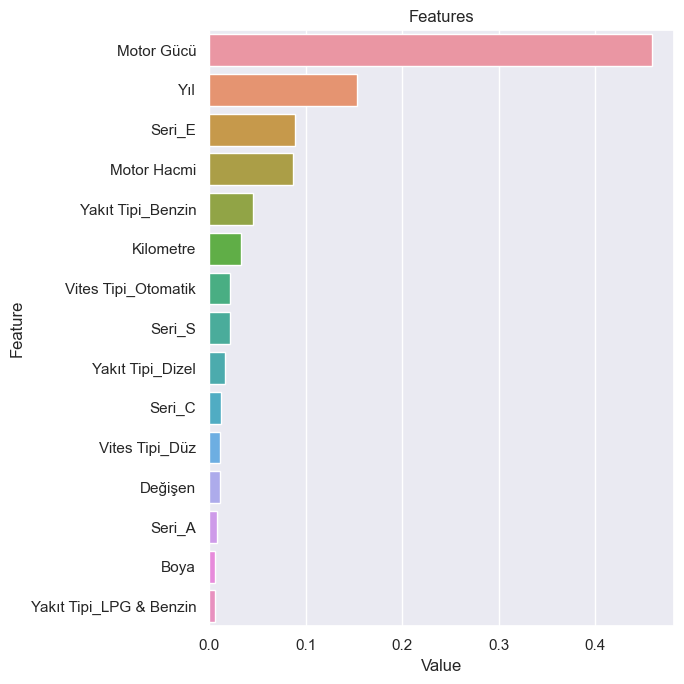

In [16]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    plt.figure(figsize=(7, 7))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:15])
    plt.title("Features")
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig("importances.png")
plot_importance(grid_final_model,X)